In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import datetime

#anomaly detection
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import QuantileAD

In [2]:
data = pd.read_csv('Data/Engagements - ds_exercise.csv')

In [3]:
data.head()

,member_id,member_program_id,time_spent,service_date,care_extender_id,program_id
0,20220,20767,1.0,2020-01-01,88,29
1,20298,20854,10.0,2020-01-01,25,29
2,19981,20528,1.0,2020-01-01,88,29
3,19542,20033,1.0,2020-01-01,49,79
4,15999,16484,10.0,2020-01-01,126,10


In [4]:
print("The start date is {}".format(data['service_date'].min()))
print("The end date is {}".format(data['service_date'].max()))

The start date is 2020-01-01
The end date is 2020-06-26


In [5]:
# Assigning a new column that denotes the week no.
data['service_time'] = pd.to_datetime(data['service_date'], format='%Y-%m-%d')
data['week_no'] = data['service_time'].dt.week

## Dividing the data into three groups based on "time spent"

In [6]:
# Groupby time spent on the whole data per each member
member_wise = data.groupby('member_id')['time_spent'].agg('sum').reset_index().sort_values('time_spent', ascending=False)
member_wise.head()

,member_id,time_spent
8949,19981,6989.0
8948,19979,3614.0
7110,16707,3270.0
6839,16411,2920.0
9416,20816,2530.0


I have used pd.qcut to create groups. **qcut** tries to split the underlying data into bins of equal size.
The method determines the bins by using percentiles based on the data distribution, not the bins' actual numeric edges. However, the bins created for this particular data do not seem to of the same size and my assumption is that due to repeated values, bin sizes are not equal.

In [7]:
member_wise['time_spent'].describe()

count    14063.000000
mean       124.698784
std        200.828716
min          0.000000
25%         16.000000
50%         50.000000
75%        150.000000
max       6989.000000
Name: time_spent, dtype: float64

In [8]:
member_wise['group'] = pd.qcut(member_wise['time_spent'], 3, labels=[0, 1, 2]) 

In [9]:
print("Average, Mininum, and Maximum time spent by members that are in group 0: {} mins, {} mins, {} mins".format(round(member_wise[member_wise['group'] == 0]['time_spent'].mean(), 2), 
                                                                                                  member_wise[member_wise['group'] == 0]['time_spent'].min(), 
                                                                                                  member_wise[member_wise['group']==0]['time_spent'].max()))

print("Average, Mininum, and Maximum time spent by members that are in group 1: {} mins, {} mins, {} mins".format(round(member_wise[member_wise['group'] == 1]['time_spent'].mean(), 2), 
                                                                                                  member_wise[member_wise['group'] == 1]['time_spent'].min(), 
                                                                                                  member_wise[member_wise['group']==1]['time_spent'].max()))

print("Average, Mininum, and Maximum time spent by members that are in group 2: {} mins, {} mins, {} mins".format(round(member_wise[member_wise['group'] == 2]['time_spent'].mean(), 2), 
                                                                                                  member_wise[member_wise['group'] == 2]['time_spent'].min(), 
                                                                                                  member_wise[member_wise['group']==2]['time_spent'].max()))


Average, Mininum, and Maximum time spent by members that are in group 0: 11.44 mins, 0.0 mins, 22.0 mins
Average, Mininum, and Maximum time spent by members that are in group 1: 56.18 mins, 23.0 mins, 105.0 mins
Average, Mininum, and Maximum time spent by members that are in group 2: 309.18 mins, 106.0 mins, 6989.0 mins


## Any anomalies?

### Type 1 - Out of behaviour

To detect anomaly time points when time spent is above 95% percentile or below 1% percentile.

In [10]:
def analyze_member(member_id):
    member_data = data[data['member_id'] == member_id][['service_date', 'time_spent']]
    member_data['service_date'] = pd.to_datetime(member_data['service_date'], format='%Y-%m-%d')
    member_data.set_index('service_date', inplace = True)
    
    s = validate_series(member_data)
    
    quantile_ad = QuantileAD(high=0.95, low=0.01)
    anomalies = quantile_ad.fit_detect(s)
    
    plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

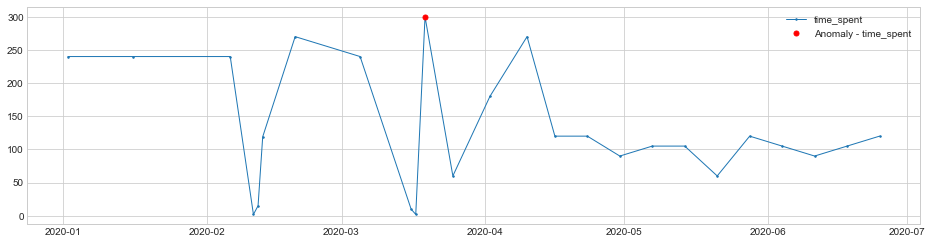

In [11]:
#Can be used to analyze any member
analyze_member(19979)

In [12]:
def analyze_care_extender(care_extender_id):
    care_data = data[data['care_extender_id'] == care_extender_id][['service_date', 'time_spent']]
    care_data['service_date'] = pd.to_datetime(care_data['service_date'], format='%Y-%m-%d')
    care_data.set_index('service_date', inplace = True)
    
    s = validate_series(care_data)
    
    quantile_ad = QuantileAD(high=0.95, low=0.01)
    anomalies = quantile_ad.fit_detect(s)
    
    plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
    

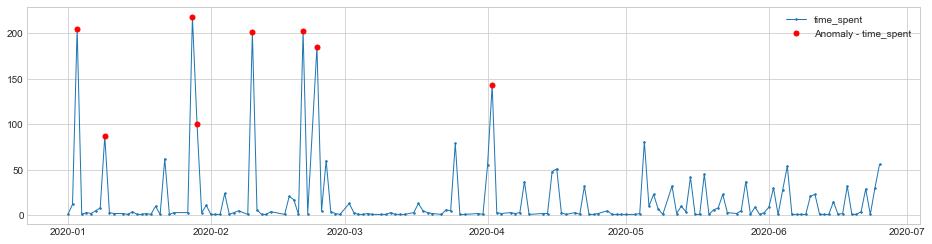

In [13]:
# Can be used to analyze any care extender
analyze_care_extender(88)

### Type 2a - Average time spent by each member per week

Here I have sorted the data weekly and got the average time spent by each member per week. Then I created a function that takes member id as input and counts the how many times they have spent same number of mins for the given 26 weeks. This function returns the member id and the counts of their average time as a list. I computed the total number of weeks they have had same mins average for by taking the max of counts. So, I kind of just assumed that anyone who has had same average mins for more than 10 weeks is like a "red flag".

In [14]:
average_per_week = data.groupby(['member_id', 'week_no'])['time_spent'].mean().reset_index().sort_values('time_spent', ascending = False)
print("Total number of entries weekly: {}".format(len(average_per_week)))
average_per_week.head()

Total number of entries weekly: 82978


,member_id,week_no,time_spent
59585,19979,15,270.0
59886,20092,11,262.5
59578,19979,6,240.0
59577,19979,3,240.0
59581,19979,10,240.0


In [15]:
def weekly_anomaly(member_id):
    member_data = average_per_week[average_per_week['member_id'] == member_id]
    counts = list(member_data['time_spent'].value_counts())
    return [member_id, counts]

In [16]:
ids = average_per_week['member_id'].apply(lambda x: weekly_anomaly(x))

In [17]:
print("The first value of the column is the member id and the second value which is the list has the counts of their average week")
s = ids.to_frame()
s.head()

The first value of the column is the member id and the second value which is the list has the counts of their average week


,member_id
59585,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"
59886,"[20092, [3, 1, 1]]"
59578,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"
59577,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"
59581,"[19979, [4, 4, 4, 2, 2, 1, 1, 1, 1, 1]]"


In [18]:
new_col_list = ['members_id', 'counts' ]
for n,col in enumerate(new_col_list):
    s[col] = s['member_id'].apply(lambda x: x[n])
    
s = s.drop('member_id',axis=1)

In [19]:
s = s[s['counts'].apply(len) > 0]

In [20]:
s['max_count'] = s['counts'].apply(lambda x: max(x))
s = s[s['max_count'] > 8]
s = s.drop('counts',axis=1)

In [21]:
s = s.sort_values('max_count', ascending = False)
print("Total number of Ids that are flagged: {}".format(len(s)))
s.head()

Total number of Ids that are flagged: 11696


,members_id,max_count
36459,14294,23
9300,3488,23
9295,3488,23
9296,3488,23
9289,3488,23
